In [164]:
# print_function for compatibility with Python 3
from __future__ import print_function 
#print('Print function from python 3')

# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd

# Matplotlib for visualization
import matplotlib.pyplot as plt

# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns

import calendar
import datetime

In [165]:
df = pd.read_csv('turnstile_160409.txt')

In [166]:
df.columns = df.columns.str.strip()

In [167]:
df['turnstile_id'] = df['C/A'] + '_' + df['UNIT'] + '_' + df['SCP'] + '_' + df['STATION']

In [168]:
#Convert data types to reduce file size
df['C/A'] = df['C/A'].astype('category')
df['DIVISION'] = df['DIVISION'].astype('category')
df['UNIT'] = df['UNIT'].astype('category')
df['ENTRIES'] = df['ENTRIES'].astype('int32')
df['EXITS'] = df['EXITS'].astype('int32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194516 entries, 0 to 194515
Data columns (total 12 columns):
C/A             194516 non-null category
UNIT            194516 non-null category
SCP             194516 non-null object
STATION         194516 non-null object
LINENAME        194516 non-null object
DIVISION        194516 non-null category
DATE            194516 non-null object
TIME            194516 non-null object
DESC            194516 non-null object
ENTRIES         194516 non-null int32
EXITS           194516 non-null int32
turnstile_id    194516 non-null object
dtypes: category(3), int32(2), object(7)
memory usage: 12.8+ MB


In [169]:
df['date'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')

In [170]:
entries_list = list(df.groupby(['turnstile_id', 'date'])['ENTRIES'].apply(list))
exits_list = list(df.groupby(['turnstile_id', 'date'])['EXITS'].apply(list))

In [171]:
entries_count = []
for en in entries_list:
    entries_count.append(en[-1] - en[0])

exits_count = []
for ex in exits_list:
    exits_count.append(ex[-1] - ex[0])

In [172]:
df_turnstile_counts = df.groupby(['turnstile_id', 'date']).count()
df_turnstile_counts.drop(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'TIME', 'DESC', 'ENTRIES', 'EXITS', 'DATE'], axis=1, inplace=True)
df_turnstile_counts['entries_list'] = entries_list
df_turnstile_counts['exits_list'] = exits_list
df_turnstile_counts['entries_count'] = entries_count
df_turnstile_counts['exits_count'] = exits_count
df_turnstile_counts['entries_exits'] = df_turnstile_counts['entries_count'] + df_turnstile_counts['exits_count']
df_turnstile_counts.reset_index(inplace=True)

df_turnstile_counts.head()

,turnstile_id,date,entries_list,exits_list,entries_count,exits_count,entries_exits
0,A002_R051_02-00-00_59 ST,2016-04-02,"[5600838, 5600863, 5600877, 5600922, 5601172, ...","[1896290, 1896293, 1896313, 1896375, 1896445, ...",646,234,880
1,A002_R051_02-00-00_59 ST,2016-04-03,"[5601621, 5601638, 5601643, 5601722, 5601917, ...","[1896558, 1896566, 1896578, 1896648, 1896718, ...",529,211,740
2,A002_R051_02-00-00_59 ST,2016-04-04,"[5602244, 5602256, 5602297, 5602326, 5602456, ...","[1896791, 1896793, 1896893, 1896945, 1897174, ...",1189,561,1750
3,A002_R051_02-00-00_59 ST,2016-04-05,"[5603671, 5603729, 5603886, 5604169, 5604944]","[1897387, 1897497, 1897817, 1897905, 1898006]",1273,619,1892
4,A002_R051_02-00-00_59 ST,2016-04-06,"[5605129, 5605137, 5605168, 5605278, 5605583, ...","[1898051, 1898054, 1898158, 1898357, 1898440, ...",1249,478,1727


In [173]:
df_turnstile_counts['station'] = df_turnstile_counts['turnstile_id'].str.slice(19)

In [174]:
df_station_sum = df_turnstile_counts.groupby(['station', 'date'])[['entries_count','exits_count', 'entries_exits']].sum()
df_station_sum.head()

entries_count  exits_count  entries_exits
station date                                                 
1 AV    2016-04-02          15739        10625          26364
        2016-04-03          12836         8962          21798
        2016-04-04          19091        13968          33059
        2016-04-05          18673        12222          30895
        2016-04-06          21212        13427          34639

In [175]:
df_turnstile_counts['first_entry'] = [x[0] for x in df_turnstile_counts.entries_list]
df_turnstile_counts['first_exit'] = [x[0] for x in df_turnstile_counts.exits_list]

In [176]:
df_turnstile_counts[["PREV_DATE", "PREV_ENTRIES"]] = (df_turnstile_counts
                                                       .groupby('turnstile_id')['date', 'first_entry']
                                                       .transform(lambda grp: grp.shift(1)))
df_turnstile_counts['PREV_EXITS'] = (df_turnstile_counts
                                                       .groupby('turnstile_id')['first_exit']
                                                       .transform(lambda grp: grp.shift(1)))

In [177]:
df_turnstile_counts.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

# summarize 
df_turnstile_counts['shift_entries'] = df_turnstile_counts['first_entry'] - df_turnstile_counts['PREV_ENTRIES']
df_turnstile_counts['shift_exits'] = df_turnstile_counts['first_exit'] - df_turnstile_counts['PREV_EXITS']
df_turnstile_counts.head()

,turnstile_id,date,entries_list,exits_list,entries_count,exits_count,entries_exits,station,first_entry,first_exit,PREV_DATE,PREV_ENTRIES,PREV_EXITS,shift_entries,shift_exits
1,A002_R051_02-00-00_59 ST,2016-04-03,"[5601621, 5601638, 5601643, 5601722, 5601917, ...","[1896558, 1896566, 1896578, 1896648, 1896718, ...",529,211,740,59 ST,5601621,1896558,2016-04-02,5600838.0,1896290.0,783.0,268.0
2,A002_R051_02-00-00_59 ST,2016-04-04,"[5602244, 5602256, 5602297, 5602326, 5602456, ...","[1896791, 1896793, 1896893, 1896945, 1897174, ...",1189,561,1750,59 ST,5602244,1896791,2016-04-03,5601621.0,1896558.0,623.0,233.0
3,A002_R051_02-00-00_59 ST,2016-04-05,"[5603671, 5603729, 5603886, 5604169, 5604944]","[1897387, 1897497, 1897817, 1897905, 1898006]",1273,619,1892,59 ST,5603671,1897387,2016-04-04,5602244.0,1896791.0,1427.0,596.0
4,A002_R051_02-00-00_59 ST,2016-04-06,"[5605129, 5605137, 5605168, 5605278, 5605583, ...","[1898051, 1898054, 1898158, 1898357, 1898440, ...",1249,478,1727,59 ST,5605129,1898051,2016-04-05,5603671.0,1897387.0,1458.0,664.0
5,A002_R051_02-00-00_59 ST,2016-04-07,"[5606603, 5606619, 5606656, 5606803, 5607108, ...","[1898562, 1898565, 1898680, 1898963, 1899032, ...",1265,583,1848,59 ST,5606603,1898562,2016-04-06,5605129.0,1898051.0,1474.0,511.0


In [178]:
turnstile_df = df_turnstile_counts.drop(['entries_list', 'exits_list', 'first_entry', 'first_exit', 'PREV_ENTRIES', 'PREV_EXITS'], axis=1)
turnstile_df.head()

,turnstile_id,date,entries_count,exits_count,entries_exits,station,PREV_DATE,shift_entries,shift_exits
1,A002_R051_02-00-00_59 ST,2016-04-03,529,211,740,59 ST,2016-04-02,783.0,268.0
2,A002_R051_02-00-00_59 ST,2016-04-04,1189,561,1750,59 ST,2016-04-03,623.0,233.0
3,A002_R051_02-00-00_59 ST,2016-04-05,1273,619,1892,59 ST,2016-04-04,1427.0,596.0
4,A002_R051_02-00-00_59 ST,2016-04-06,1249,478,1727,59 ST,2016-04-05,1458.0,664.0
5,A002_R051_02-00-00_59 ST,2016-04-07,1265,583,1848,59 ST,2016-04-06,1474.0,511.0


In [179]:
turnstile_df['station'] = turnstile_df['turnstile_id'].str.slice(19)
station_df = turnstile_df.groupby(['station', 'date'])[['entries_count','exits_count', 'entries_exits', 'shift_entries', 'shift_exits']].sum()
station_df.reset_index(inplace=True)
station_df.head()

,station,date,entries_count,exits_count,entries_exits,shift_entries,shift_exits
0,1 AV,2016-04-03,12836,8962,21798,20472.0,13691.0
1,1 AV,2016-04-04,19091,13968,33059,15547.0,10470.0
2,1 AV,2016-04-05,18673,12222,30895,22231.0,15732.0
3,1 AV,2016-04-06,21212,13427,34639,22369.0,14272.0
4,1 AV,2016-04-07,20852,13336,34188,25382.0,15420.0


---

convert stuff in to weekdays

In [180]:
station_df['day_of_week'] = [calendar.day_name[i.weekday()] for i in station_df.date]

In [181]:
station_df.head()

,station,date,entries_count,exits_count,entries_exits,shift_entries,shift_exits,day_of_week
0,1 AV,2016-04-03,12836,8962,21798,20472.0,13691.0,Sunday
1,1 AV,2016-04-04,19091,13968,33059,15547.0,10470.0,Monday
2,1 AV,2016-04-05,18673,12222,30895,22231.0,15732.0,Tuesday
3,1 AV,2016-04-06,21212,13427,34639,22369.0,14272.0,Wednesday
4,1 AV,2016-04-07,20852,13336,34188,25382.0,15420.0,Thursday


---

**drop entry count that is less than zero**

In [184]:
station_df =station_df.drop(station_df[station_df.entries_count < 0].index)

In [186]:
station_df.head()

,station,date,entries_count,exits_count,entries_exits,shift_entries,shift_exits,day_of_week
0,1 AV,2016-04-03,12836,8962,21798,20472.0,13691.0,Sunday
1,1 AV,2016-04-04,19091,13968,33059,15547.0,10470.0,Monday
2,1 AV,2016-04-05,18673,12222,30895,22231.0,15732.0,Tuesday
3,1 AV,2016-04-06,21212,13427,34639,22369.0,14272.0,Wednesday
4,1 AV,2016-04-07,20852,13336,34188,25382.0,15420.0,Thursday


---

_find top 20 station idea is to include all weekdays that is **68**_

In [188]:
top_20_station=station_df.sort_values(by='entries_count',ascending=False).head(68)

In [189]:
top_20_unique_station=top_20_station['station'].unique()

In [190]:
len(top_20_unique_station)

16

In [191]:
top_20_station.head()

,station,date,entries_count,exits_count,entries_exits,shift_entries,shift_exits,day_of_week
56,125 ST,2016-04-05,2572033886,1804892995,4376926881,70737.0,59643.0,Tuesday
361,36 ST,2016-04-04,285242746,-134210124,151032622,6965.0,5665.0,Monday
1016,CHAMBERS ST,2016-04-05,33594299,-16736059,16858240,79022.0,44230.0,Tuesday
2439,_THIRTY ST,2016-04-06,1909390,770694,2680084,-1890256.0,-748336.0,Wednesday
2440,_THIRTY ST,2016-04-07,1907077,771394,2678471,12825.0,9910.0,Thursday


In [192]:
station_list=top_20_station.station.tolist()

In [193]:
top_20_station.groupby(['station','day_of_week'])['entries_count'].sum()

station          day_of_week
125 ST           Friday              63783
                 Monday              64972
                 Thursday            61442
                 Tuesday        2572033886
                 Wednesday           64329
14 ST-UNION SQ   Friday              97620
                 Monday              88975
                 Thursday            93125
                 Tuesday             96127
                 Wednesday           96238
23 ST            Friday              96116
                 Monday              96868
                 Thursday            98191
                 Tuesday            101059
                 Wednesday          102311
34 ST-HERALD SQ  Friday             102901
                 Monday              99245
                 Thursday           100161
                 Tuesday            103783
                 Wednesday          103187
34 ST-PENN STA   Friday             157278
                 Monday             164813
                 Sunday  

In [197]:
top_20_station_entry_count = top_20_station.groupby(by='station', as_index=False).sum()[['station','entries_count']].sort_values('entries_count', ascending=False)

In [198]:
top_20_station_entry_count 

,station,entries_count
0,125 ST,2572288412
5,36 ST,285242746
10,CHAMBERS ST,33880779
15,_THIRTY ST,3816467
4,34 ST-PENN STA,882168
7,86 ST,519517
3,34 ST-HERALD SQ,509277
12,GRD CNTRL-42 ST,503038
2,23 ST,494545
13,GUN HILL RD,472736


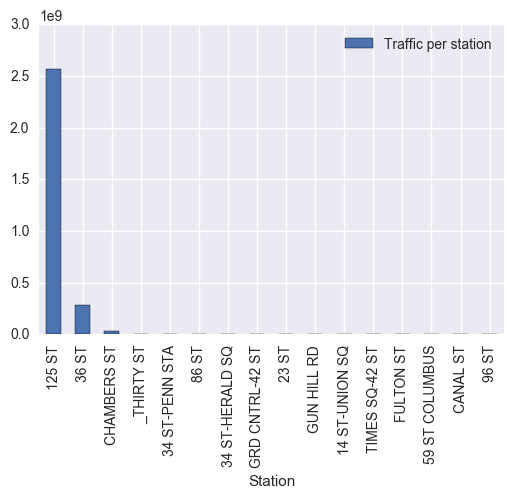

In [200]:
top_20_station_entry_count.plot(kind='bar', x='station', y='entries_count',label='Traffic per station')
plt.xlabel('Station')

In [205]:
top_20_station_entry_count_new=top_20_station_entry_count.drop(top_20_station_entry_count[top_20_station_entry_count.entries_count > 3716467].index)

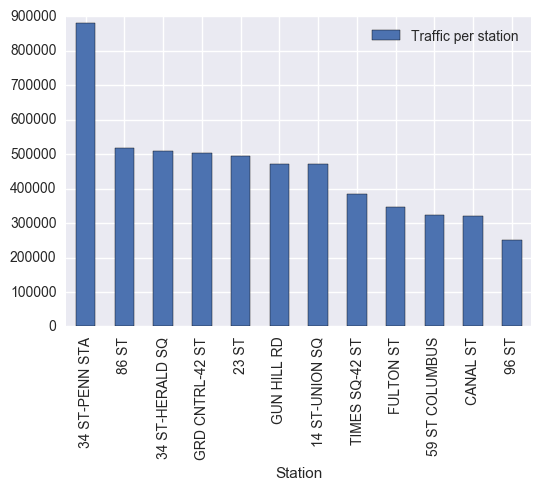

In [206]:
top_20_station_entry_count_new.plot(kind='bar', x='station', y='entries_count',label='Traffic per station')
plt.xlabel('Station')

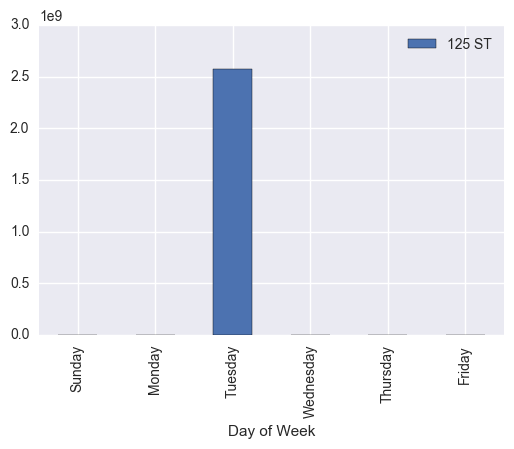

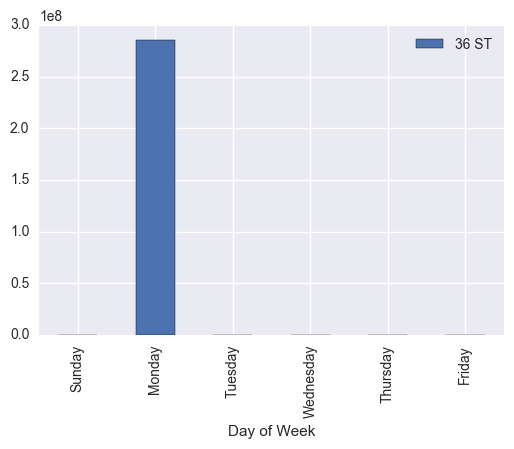

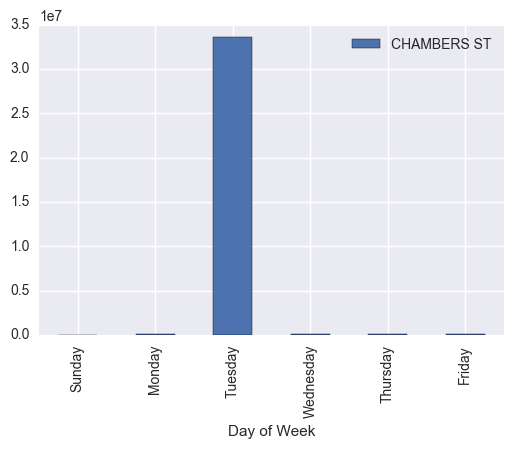

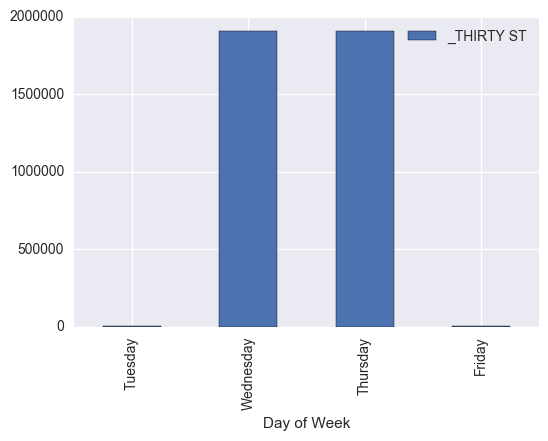

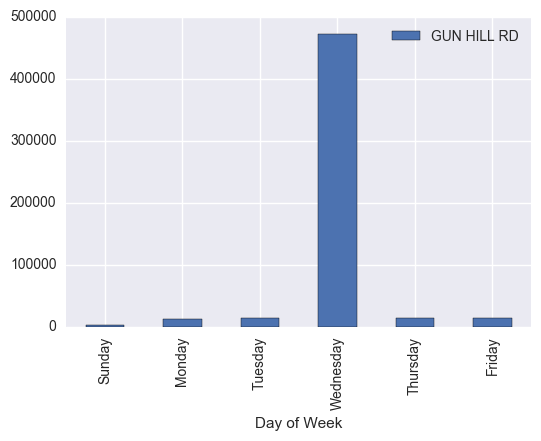

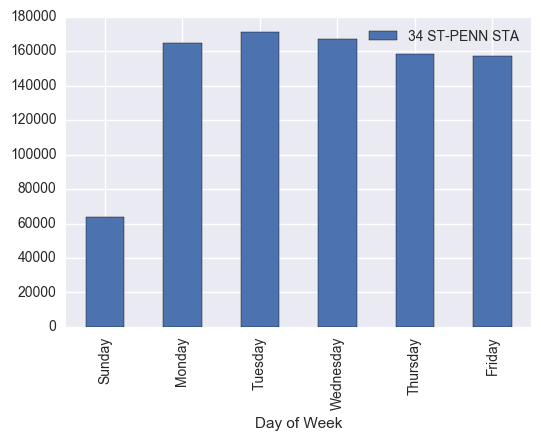

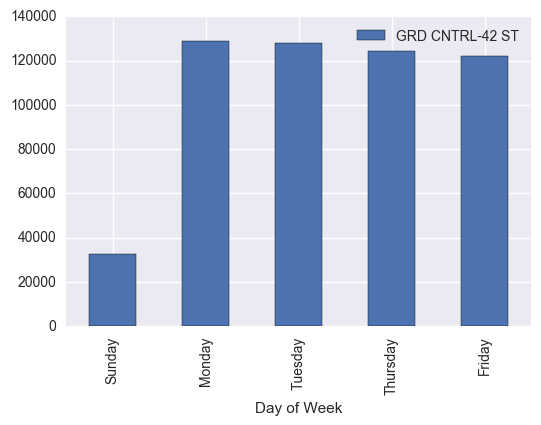

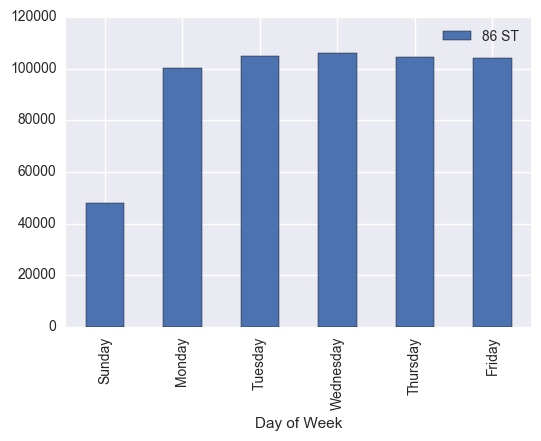

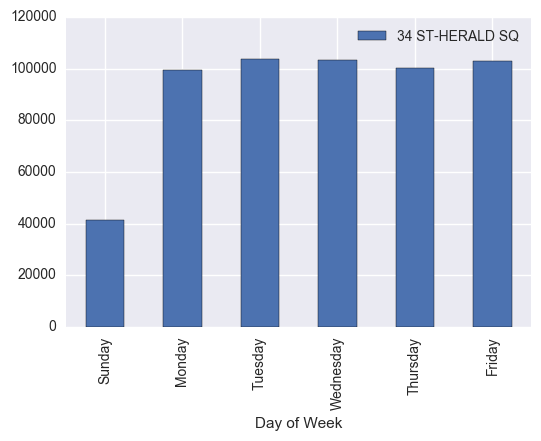

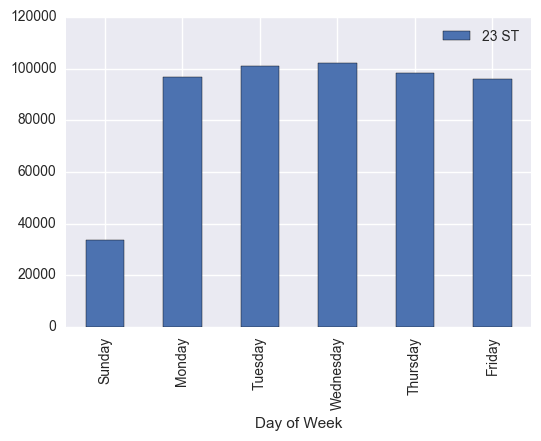

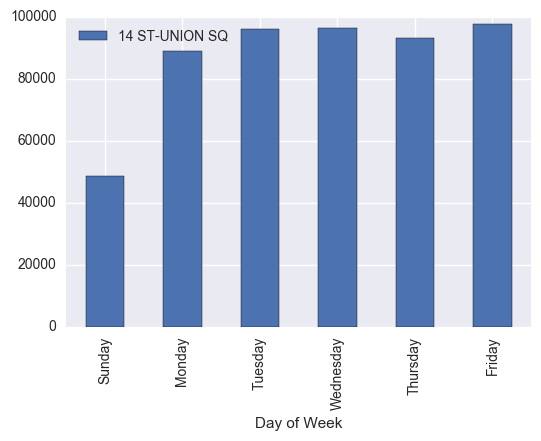

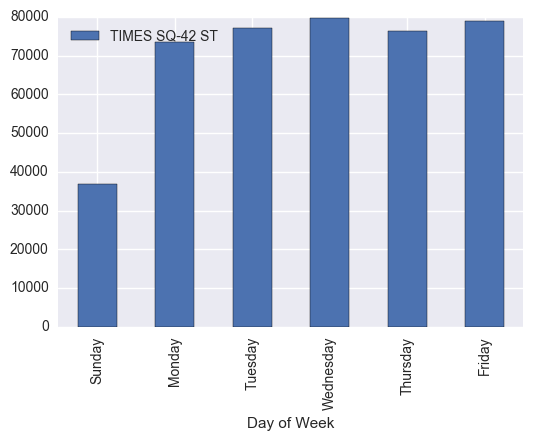

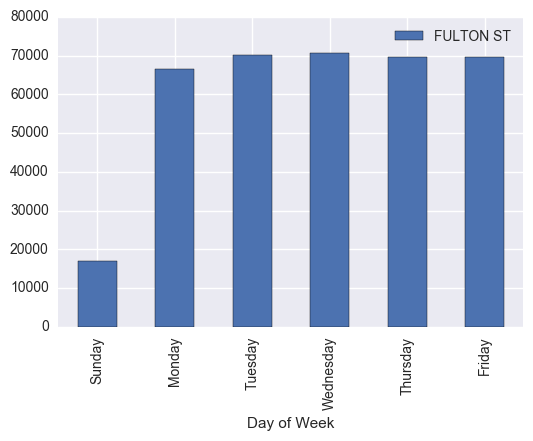

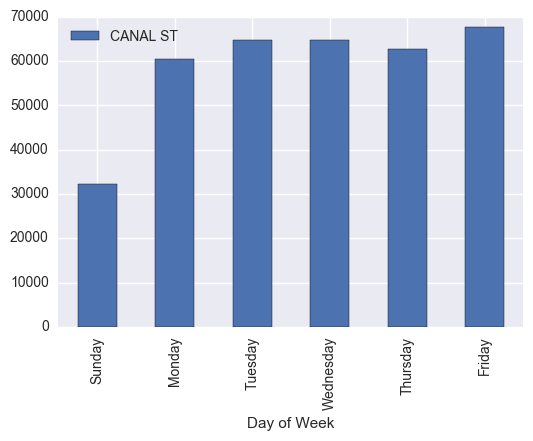

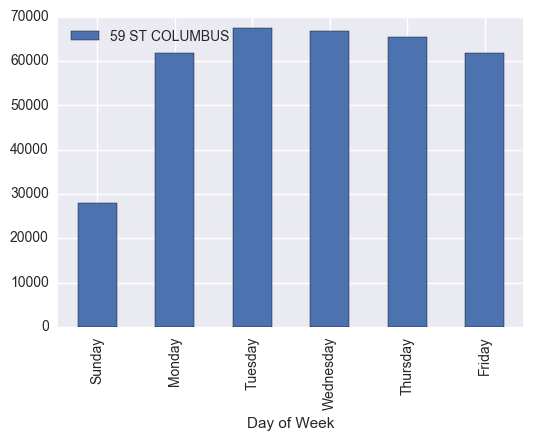

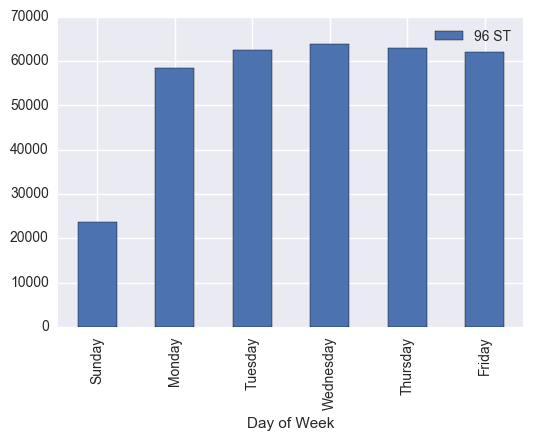

In [207]:
for s in top_20_unique_station:
    df_new=pd.DataFrame()
    df_new=station_df[station_df['station']==s]
    df_new.plot(kind='bar', x='day_of_week', y='entries_count',label=s)
    plt.xlabel('Day of Week')

In [208]:
station_df_new=station_df.drop(station_df[station_df.entries_count > 3716467].index)

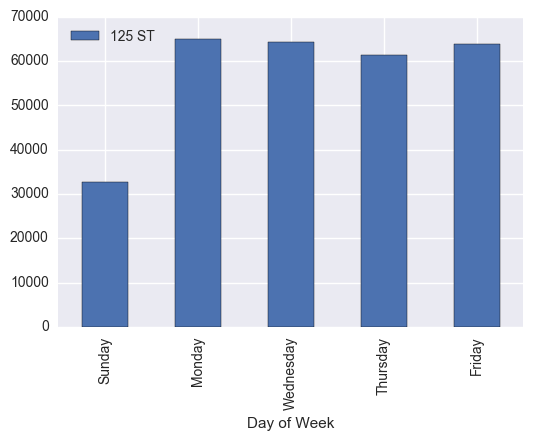

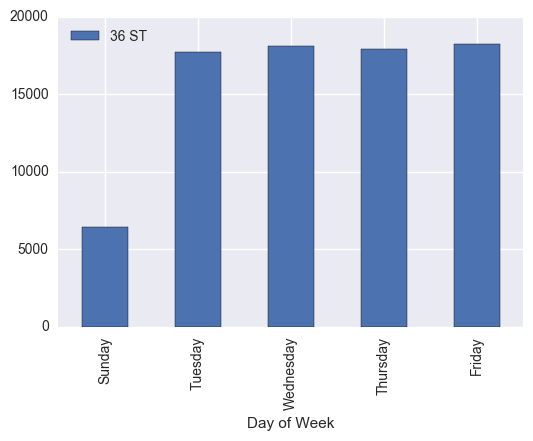

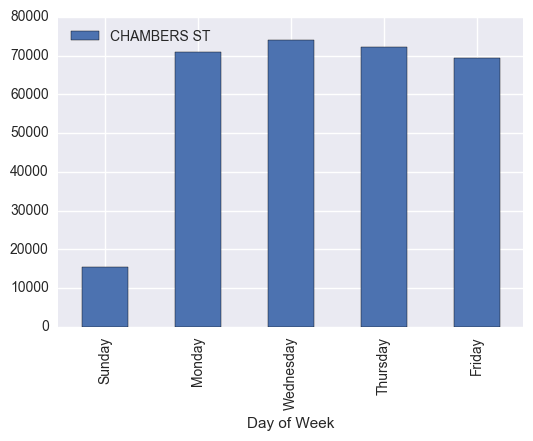

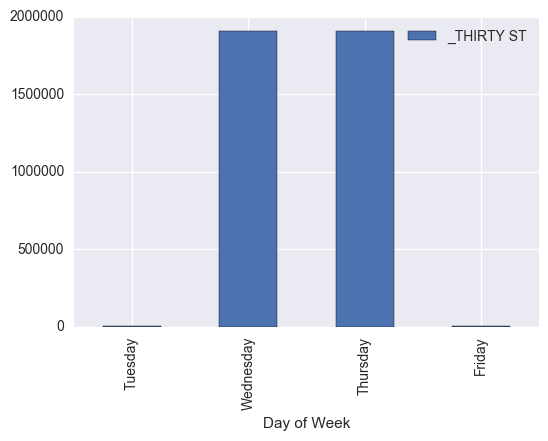

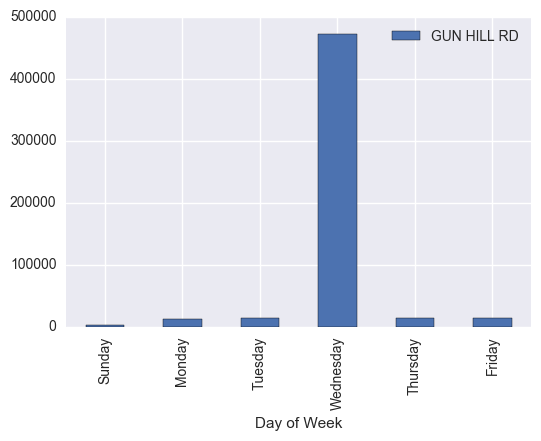

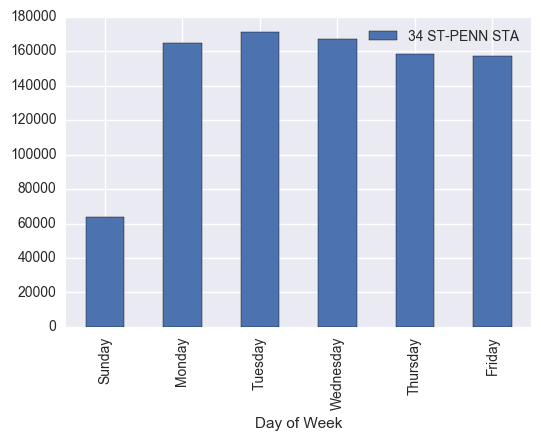

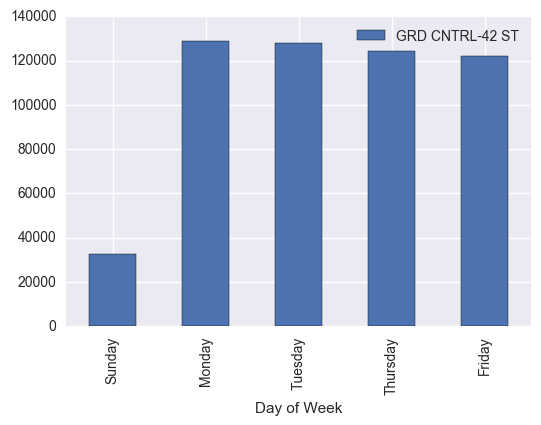

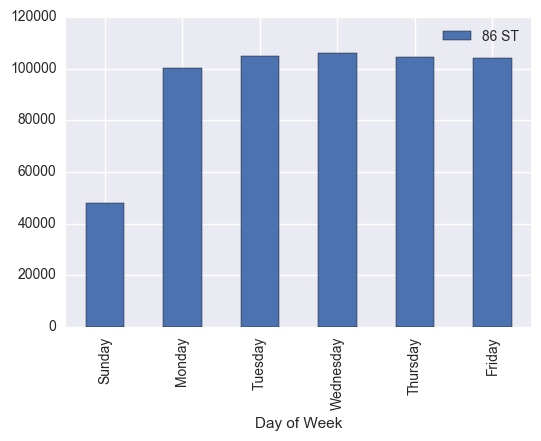

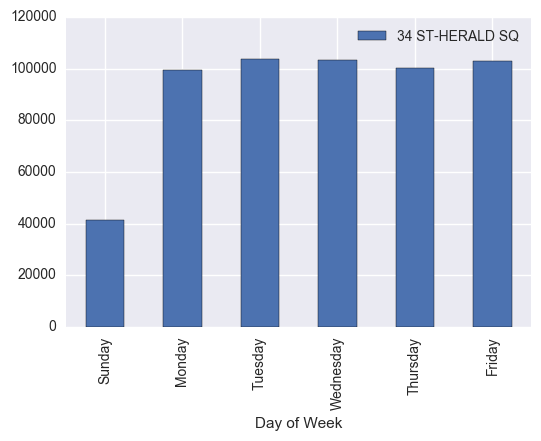

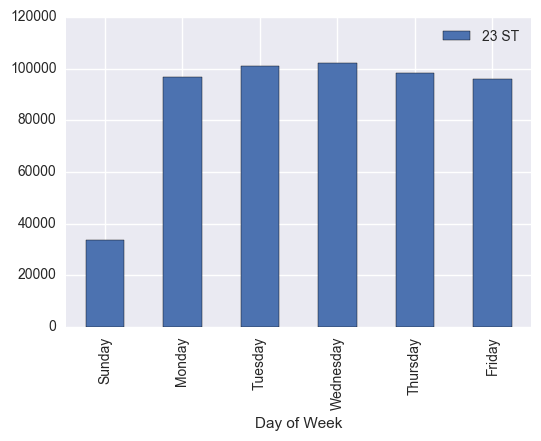

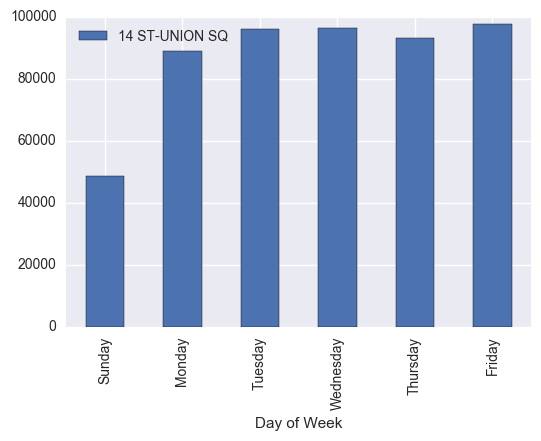

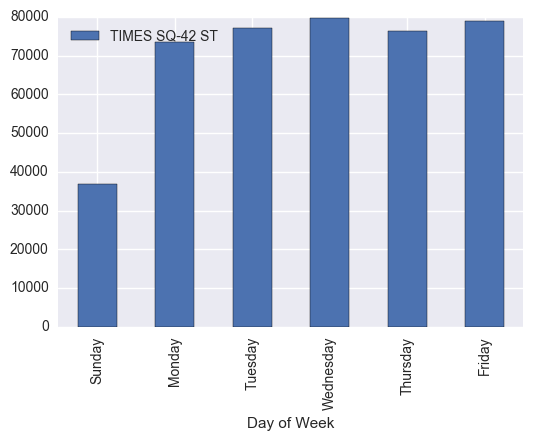

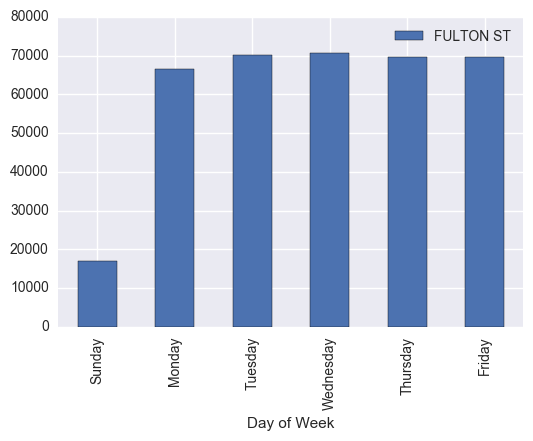

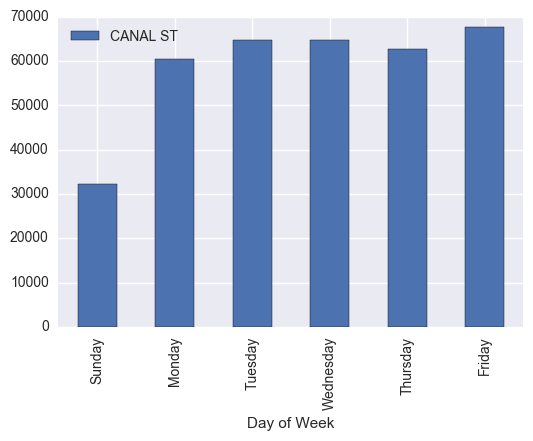

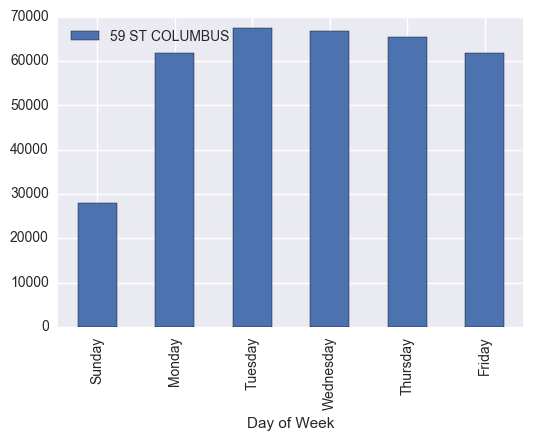

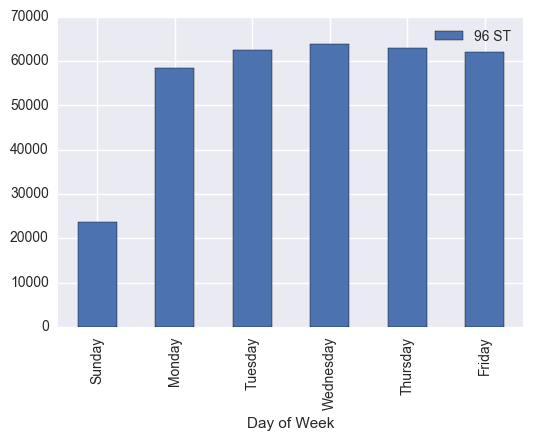

In [210]:
for s in top_20_unique_station:
    df_new=pd.DataFrame()
    df_new=station_df_new[station_df_new['station']==s]
    df_new.plot(kind='bar', x='day_of_week', y='entries_count',label=s)
    plt.xlabel('Day of Week')